In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import torchaudio.functional as F_audio
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from read_data import RIRData
from sklearn.model_selection import train_test_split
import librosa
import soundfile as sf

In [2]:
data = RIRData("/home/lucas/ML/gtu-rir/RIR.pickle.dat")

all_rir_values = [entry[data.rir_data_field_numbers["rirData"]] for entry in data.rir_data]


rirData Length =15202


In [3]:
# Get a list of all the MFCC for all the RIRs
all_mfcc = []
for i in range(len(all_rir_values)):
    # Get the MFCC for the current RIR
    mfcc = T.MFCC(
        sample_rate=22050,
        n_mfcc=20,
        melkwargs={"n_fft": 2048, "hop_length": 512, "n_mels": 128},
    )
    mfcc_values = mfcc(torch.tensor(all_rir_values[i], dtype=torch.float32))
    all_mfcc.append(mfcc_values)

# print the shape of the MFCC values
print("MFCC shape:", all_mfcc[0].shape) # (20, 173)

MFCC shape: torch.Size([20, 173])


In [4]:
# normalize the MFCC values
all_mfcc = [F.normalize(mfcc, p=2, dim=1) for mfcc in all_mfcc]
# print the shape of the normalized MFCC values
print("Normalized MFCC shape:", all_mfcc[0].shape) # shape(20, 173)

Normalized MFCC shape: torch.Size([20, 173])


In [6]:
# Split the data into training and testing sets
train_mfcc, test_mfcc = train_test_split(all_mfcc, test_size=0.2, random_state=42)
# print the shapes of the training and testing sets
print("Training MFCC shape:", train_mfcc[0].shape)
print("Testing MFCC shape:", test_mfcc[0].shape)
# Create a dataset class
class RIRDataset(Dataset):
    def __init__(self, mfcc_data):
        self.mfcc_data = mfcc_data

    def __len__(self):
        return len(self.mfcc_data)

    def __getitem__(self, idx):
        return self.mfcc_data[idx]
# Create the training and testing datasets
train_dataset = RIRDataset(train_mfcc)
test_dataset = RIRDataset(test_mfcc)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4)

Training MFCC shape: torch.Size([20, 173])
Testing MFCC shape: torch.Size([20, 173])


In [7]:
# Defining the sliced Wasserstein distance

def sliced_wasserstein_distance(z, prior_z, num_projections=100):

    batch,dim = z.size()
    # Generate random projections
    directions = F.normalize(torch.randn(num_projections, dim, device=z.device), dim=1)

    # Projetar directions
    z_proj = z @ directions.T
    prior_z_proj = prior_z @ directions.T
    # Sort the projections
    z_proj_sorted = z_proj.sort(dim=1).values
    prior_z_proj_sorted = prior_z_proj.sort(dim=1).values
    # Compute the sliced Wasserstein distance (L2 distance)
    swd = torch.mean(torch.sqrt(torch.sum((z_proj_sorted - prior_z_proj_sorted) ** 2, dim=1)))
    return swd

In [8]:
# prepare the model

class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Encoder, self).__init__()
        
        #input_dim shape is (20, 173)
        self.convs = nn.Sequential(
                nn.Conv1d(input_dim[0], 32, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
                nn.Conv1d(32, 64, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
                nn.Conv1d(64, 128, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),
                nn.MaxPool1d(kernel_size=2, stride=2),
            )
        
        # Dummy forward pass to get the output shape
        with torch.no_grad():
            dummy_input = torch.zeros(1, input_dim[0], input_dim[1])
            dummy_output = self.convs(dummy_input)
            flat_size = dummy_output.view(1,-1).size(1)
            print("Output shape after convolutions:", dummy_output.shape)
            print("Flattened size:", flat_size)
        
        self.fc = nn.Linear(flat_size, latent_dim)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Change shape from (batch_size, 20, 173) to (batch_size, 173, 20)
        x = self.convs(x)
        x = x.view(x.size(0), -1) # Flatten the output in order to pass it to the fully connected layer
        x = self.fc(x) 
        return x
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super(Decoder, self).__init__()
        # output_shape shape is (20, 173)
        self.timesteps = output_shape[1]
        self.coeffs = output_shape[0]

        self.fc = nn.Linear(latent_dim, 128 * 3)
        
        self.deconvs = nn.Sequential(
                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.ConvTranspose1d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
                nn.ReLU(),

                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.ConvTranspose1d(64, 32, kernel_size=3, stride=2, padding=1),
                nn.ReLU(),

                nn.Upsample(scale_factor=2, mode="nearest"),
                nn.ConvTranspose1d(32, 20, kernel_size=3, stride=2, padding=1),
                nn.Tanh()
            )
        

    def forward(self, z):
        x = self.fc(z)
        x = x.view(z.size(0), 128, 3)
        x = self.deconvs(x)

        x = x[:, :, :self.timesteps]  # Ensure the output shape matches the input shape
        return x
    
class Swae(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super(Swae,self).__init__()
        self.encoder = Encoder(input_dim, latent_dim)
        self.decoder = Decoder(latent_dim, input_dim)


    def forward(self, x):
        x = x.permute(0, 2, 1)            # → (batch,20,173)
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)

        # Compute the SWD loss sampling the prior
        prior_z = torch.randn_like(z)
        swd_loss = sliced_wasserstein_distance(z, prior_z)
        return x_reconstructed, swd_loss

In [9]:
# training of the model in each epoch

def train_epoch(model, train_loader, optimizer, criterion, device, lambda_swd):
    model.train()
    total_loss, total_samples = 0, 0
    
    for x in tqdm(train_loader, desc="Training", leave=True):
        x = x.to(device)
        optimizer.zero_grad()
        
        # Forward pass 
        x_reconstructed, swd_loss = model(x)
        
        # Compute the reconstruction loss
        recon_loss = criterion(x_reconstructed, x)
        
        # Total loss
        loss = recon_loss + lambda_swd * swd_loss
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate the losses
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    # Compute average losses and samples
    
    avg_total_loss = total_loss / len(train_loader.dataset)
    
    return avg_total_loss, total_samples

In [10]:
@torch.no_grad()
def test_epoch(model, test_loader, criterion, device, lambda_swd):
    model.eval()
    total_loss, total_samples = 0, 0

    for x in tqdm(test_loader, desc="Testing", leave=True):
        x = x.to(device)
        
        # Forward pass
        x_reconstructed, swd_loss = model(x)
        
        # Compute the reconstruction loss
        recon_loss = criterion(x_reconstructed, x)
    
        # Total loss
        loss = recon_loss + lambda_swd * swd_loss
        
        # Accumulate the losses
        batch_size = x.size(0)
        total_loss += loss.item() * batch_size
        total_samples += batch_size
    
    # Compute average losses and samples
    avg_total_loss = total_loss / len(test_loader.dataset)
    return avg_total_loss, total_samples

In [16]:
# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Swae(input_dim=(20, 173), latent_dim=128).to(device)
# set the hyperparameters
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()
lambda_swd = 1.0
num_epochs = 8

#containers
train_losses = []
test_losses = []
# training loop

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    
    # Train the model
    train_loss, _ = train_epoch(model, train_loader, optimizer, criterion, device, lambda_swd)
    train_losses.append(train_loss)
    
    # Test the model
    test_loss, _ = test_epoch(model, test_loader, criterion, device, lambda_swd)
    test_losses.append(test_loss)
    
    print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
# Save the model
torch.save(model.state_dict(), "swae_model.pth")

Output shape after convolutions: torch.Size([1, 128, 3])
Flattened size: 384
Epoch 1/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 143.46it/s]


Train Loss: 2.6037, Test Loss: 2.3019
Epoch 2/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 167.81it/s]


Train Loss: 2.3311, Test Loss: 2.3943
Epoch 3/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 164.07it/s]


Train Loss: 2.3122, Test Loss: 2.2536
Epoch 4/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 170.58it/s]


Train Loss: 2.3180, Test Loss: 2.3101
Epoch 5/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 133.91it/s]


Train Loss: 2.2955, Test Loss: 2.2983
Epoch 6/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 116.24it/s]


Train Loss: 2.3125, Test Loss: 2.3614
Epoch 7/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 160.36it/s]


Train Loss: 2.2933, Test Loss: 2.3838
Epoch 8/8


Testing: 100%|██████████| 96/96 [00:00<00:00, 167.34it/s]

Train Loss: 2.2969, Test Loss: 2.2851


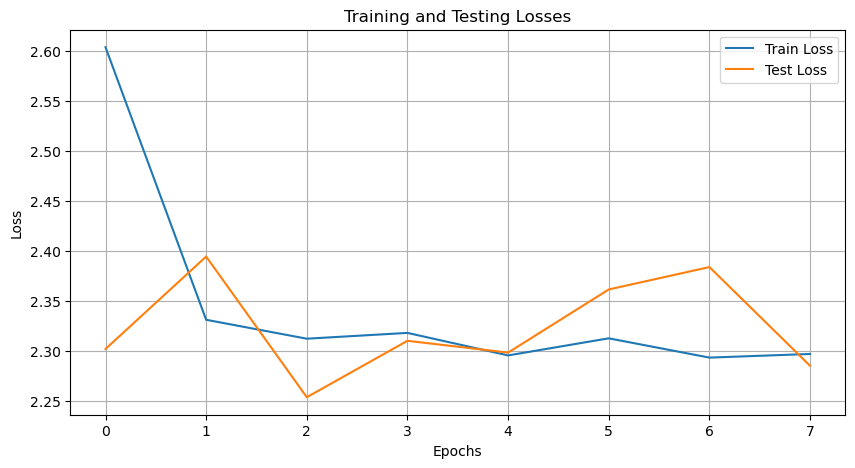

In [17]:
# Plot the training and testing losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Testing Losses")
plt.legend()
plt.grid()
plt.savefig("losses.png")
plt.show()

In [ ]:
#load the model
model = Swae(input_dim=(20, 173), latent_dim=128).to(device)
model.load_state_dict(torch.load("swae_model.pth", map_location=torch.device("cpu")))
model.eval()

In [21]:
with torch.no_grad():
    z = torch.randn(1, 128).to(device)  # Sample from the latent space
    # Decode the latent vector
    mfcc = model.decoder(z)
    mfcc = mfcc.cpu().numpy()  # Move to CPU and convert to numpy

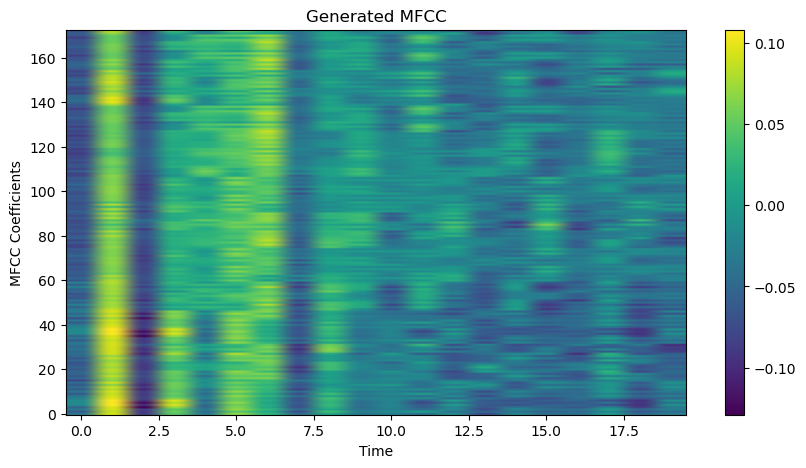

In [23]:
#plot the generated MFCC
mfcc = mfcc.squeeze(0)  # Remove the batch dimension
mfcc = mfcc.T  # Transpose to (173, 20) for plotting

plt.figure(figsize=(10, 5))
plt.imshow(mfcc, aspect='auto', origin='lower')
plt.colorbar()
plt.title("Generated MFCC")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.savefig("generated_mfcc.png")
plt.show()

In [ ]:
y = librosa.feature.inverse.mfcc_to_audio(
    mfcc,
    sr=22050, n_mels=128,
    dct_type=2, norm='ortho',
    n_fft=2048, hop_length=512, n_iter=64
)

# Save the generated audio

# Plot the generated audio
plt.figure(figsize=(10, 5))
plt.plot(y)
plt.title("Generated Audio Waveform")
plt.xlabel("Samples")
plt.ylabel("Amplitude")
plt.grid()
plt.savefig("generated_audio.png")
plt.show()

AttributeError: No librosa attribute output

: 